In [1]:
%matplotlib inline
from pprint import pprint
from metrics import wer, cew, ssr, average, hreff
import montecarlo
import withdrawal
import mortality
from portfolio import Portfolio
from harvesting import N_100_RebalanceHarvesting
from decimal import Decimal as D

import plot
from matplotlib import pyplot as plt

import pandas

In [2]:
survival_function = mortality.make_mortality(mortality.HULSTROM)

In [3]:
def run_one(rate, basecase, withdrawal_strategy):
    # The montecarlo used above has the stock/bond split baked in
    # So we pretend we have a 100% stock portfolio in order to handle
    # harvesting of cash
    p = Portfolio(1000000, 0)
    h = N_100_RebalanceHarvesting(p).harvest()
    h.send(None)
    w = withdrawal_strategy(p, h, rate=rate).withdrawals()

    cashflows = []
    returns = []
    
    # the previous year's returns
    x = None

    # Couple is assumed to be age 65 (one male, one female)
    age = mortality.gen_age(survival_function)
    for i in range(age - 65 + 1):
        # Withdrawals happen at the start of the year
        # So we first withdraw cash.
        cashflows.append(w.send(x).withdraw_pct_orig)
        
        # Then the year happens and we store the returns
        x = basecase.random_year()
        returns.append(x.stocks)

    w = wer(cashflows, returns, fudge=D('.02'))
    h = hreff(cashflows, returns, floor=D('.04'))
    return (w, h)

In [4]:
runs = 1000

In [5]:
wers = []
for i in range(runs):
    wers.append(run_one(D('.04'), montecarlo.conservative[60], withdrawal.VPW))
vpw_wer = average([w[0] for w in wers])
vpw_hreff = average([w[1] for w in wers])

In [6]:
wers = []
for i in range(runs):
    wers.append(run_one(D('.04'), montecarlo.conservative[60], withdrawal.ConstantPercentage))
endowment_wer = average([w[0] for w in wers])
endowment_hreff = average([w[1] for w in wers])

In [7]:
wers = []
for i in range(runs):
    wers.append(run_one(D('.04'), montecarlo.conservative[60], withdrawal.ConstantWithdrawals))
swr_wer = average([w[0] for w in wers])
swr_hreff = average([w[1] for w in wers])

In [8]:
wers = []
for i in range(runs):
    wers.append(run_one(D('.04'), montecarlo.conservative[60], withdrawal.EM))
em_wer = average([w[0] for w in wers])
em_hreff = average([w[1] for w in wers])

In [9]:
wers = []
for i in range(runs):
    wers.append(run_one(D('.04'), montecarlo.conservative[60], withdrawal.SimpleFormula))
simple_wer = average([w[0] for w in wers])
simple_hreff = average([w[1] for w in wers])

Constant 4%    0.679867
EM             0.757026
Endowment      0.676415
Simple         0.741208
VPW            0.769871
dtype: float64

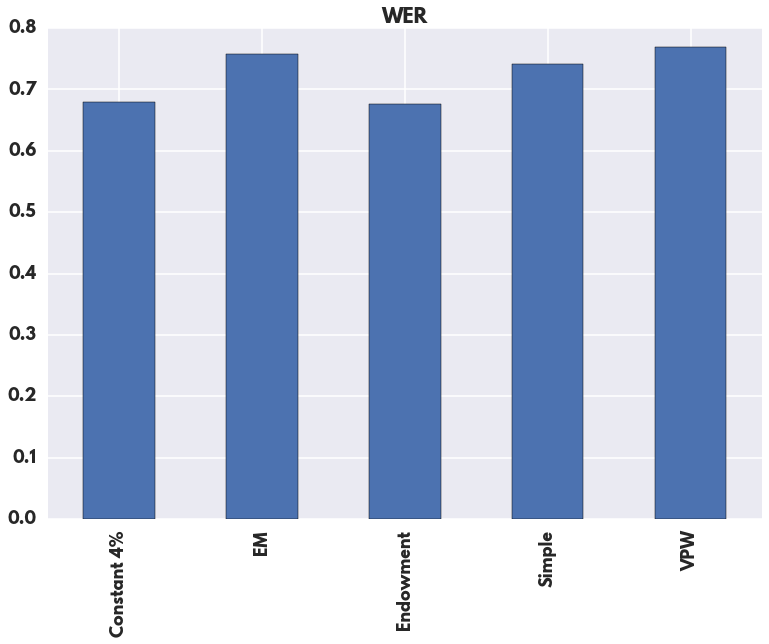

In [10]:
series = pandas.Series({
    'Constant 4%' : swr_wer,
    'Endowment' : endowment_wer,
    'EM' : em_wer,
    'VPW' : vpw_wer,
    'Simple' : simple_wer,
})

series.plot(kind='bar', title='WER')
series.head()

Constant 4%    0.575083
EM             0.718557
Endowment      0.621861
Simple         0.770697
VPW            0.769881
dtype: float64

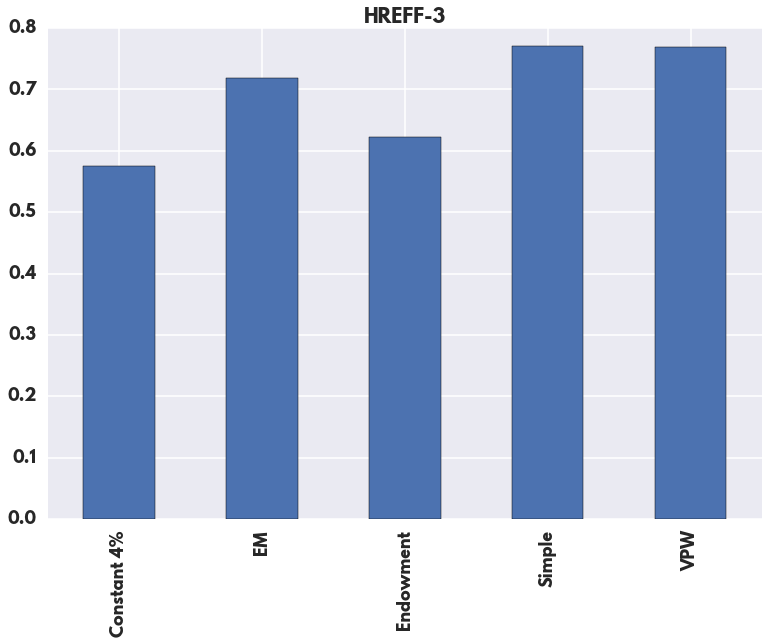

In [11]:
series = pandas.Series({
    'Constant 4%' : swr_hreff,
    'Endowment' : endowment_hreff,
    'EM' : em_hreff,
    'VPW' : vpw_hreff,
    'Simple' : simple_hreff,
})

series.plot(kind='bar', title='HREFF-3')
series.head()

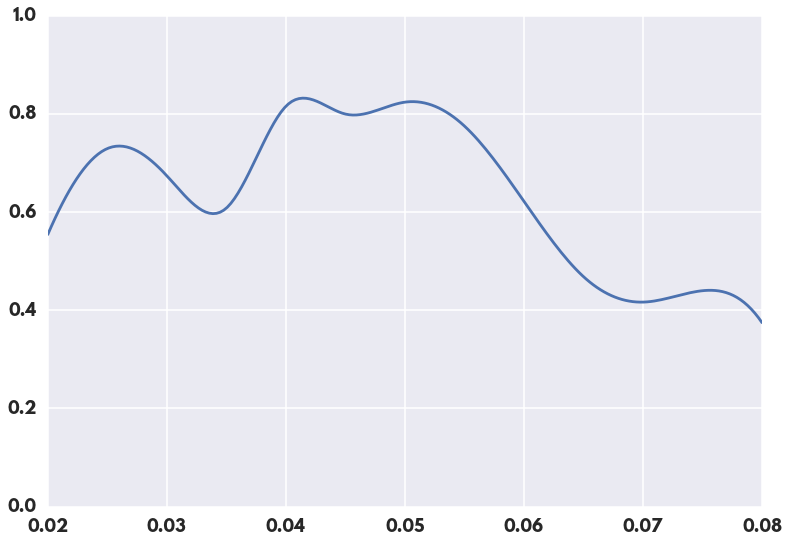

In [12]:
from scipy.interpolate import spline
import numpy as np

#canvas = plt.figure()

for equity in [0]:
    w = []
    r = []
    for rate in range(20, 81, 5):
        rate = D(rate) / 1000
        case = montecarlo.conservative[equity]

        wers = []
        for i in range(10):
            wers.append(run_one(rate, case, withdrawal.ConstantWithdrawals))
        my_wer = average([w[0] for w in wers])
        w.append(my_wer)
        r.append(rate)

    x_smooth = np.linspace(float(min(r)), float(max(r)), 200)
    y_smooth = spline(r, w, x_smooth)

    fig, ax1 = plt.subplots()
    ax1.set_ylim((0,1))
    plt.plot(x_smooth, y_smooth)